In [37]:
import numpy as np
import pandas as pd
import os

In [38]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [40]:
data_tr = pd.read_csv(os.path.join('new_data', 'data_tr.csv'), parse_dates = ['Date'], index_col = 'Date').sort_values(by = ['Date'])
data_te = pd.read_csv(os.path.join('new_data', 'data_te.csv'), parse_dates = ['Date'], index_col = 'Date').sort_values(by = ['Date'])

In [41]:
data_tr.columns = ['eurgbp', 'eurjpy', 'eurusd', 'gbpjpy', 'gbpusd', 'sp500', 't10_yield', 'vix']
data_te.columns = ['eurgbp', 'eurjpy', 'eurusd', 'gbpjpy', 'gbpusd', 'sp500', 't10_yield', 'vix']

In [42]:
currencies = ['eurgbp', 'eurjpy', 'eurusd', 'gbpjpy', 'gbpusd']
index = ['sp500', 't10_yield', 'vix']

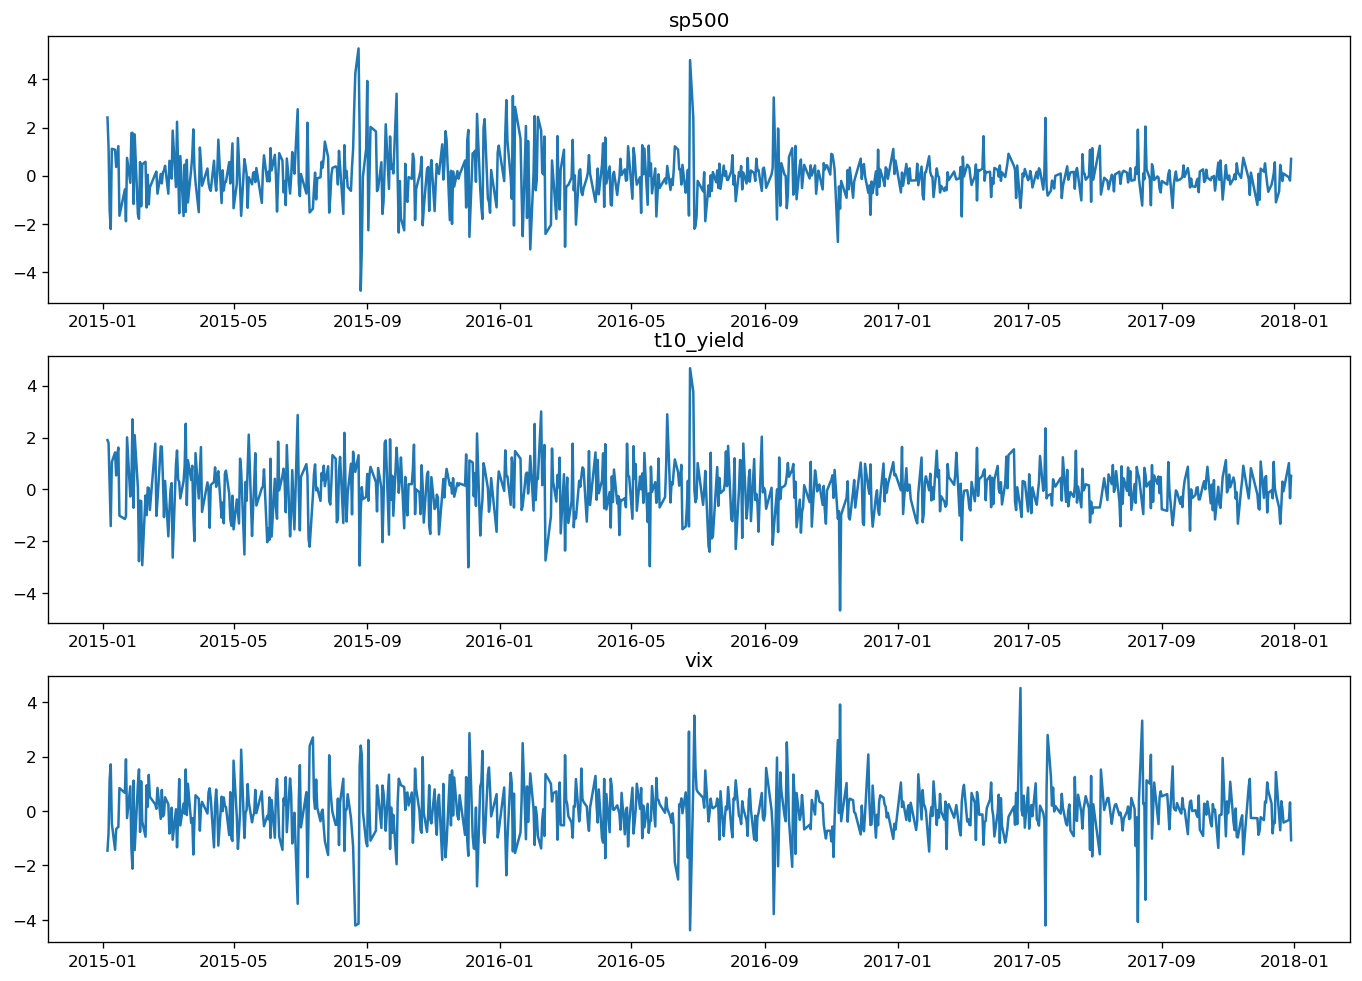

In [43]:
## Plotting
fig, axes = plt.subplots(nrows = len(index), dpi = 120, figsize = (14, 10))
for ax, ind in zip(axes, index):
    ax.plot(data_tr[ind])
    ax.set_title(ind)

In [44]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data_tr[index], variables = data_tr[index].columns) 

,sp500_x,t10_yield_x,vix_x
sp500_y,1.0000,0.1793,0.0111
t10_yield_y,0.0042,1.0000,0.1253
vix_y,0.0121,0.0503,1.0000


In [45]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data_tr[index])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
sp500  ::  381.23    > 24.2761   =>   True
t10_yield ::  234.09    > 12.3212   =>   True
vix    ::  112.25    > 4.1296    =>   True


In [46]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [47]:
# ADF Test on each column
for name, column in data_tr[index].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "sp500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0853
 No. Lags Chosen       = 9
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "t10_yield" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.7686
 No. Lags Chosen       = 4
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "vix" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0

In [48]:
model = VAR(data_tr[index])
for i in range(1, 10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.2320543276830922
BIC :  -1.1554840207274502
FPE :  0.29169283059509327
HQIC:  -1.202488265333661 

Lag Order = 2
AIC :  -1.2329730514387145
BIC :  -1.0988288007317681
FPE :  0.29142541199957067
HQIC:  -1.1811726316625486 

Lag Order = 3
AIC :  -1.2253979191146263
BIC :  -1.0335538963442483
FPE :  0.2936424386421883
HQIC:  -1.1513116653126834 

Lag Order = 4
AIC :  -1.2159091619005367
BIC :  -0.9662390841256854
FPE :  0.2964439586910059
HQIC:  -1.1194854071550098 

Lag Order = 5
AIC :  -1.2182964984506506
BIC :  -0.9106736258280893
FPE :  0.29574020645300564
HQIC:  -1.0994833845628555 

Lag Order = 6
AIC :  -1.2271336182909092
BIC :  -0.8614307517874223
FPE :  0.2931427473857788
HQIC:  -1.0858790948130068 

Lag Order = 7
AIC :  -1.2053650055098064
BIC :  -0.7814544845998008
FPE :  0.2996003912806797
HQIC:  -1.0416168287703118 

Lag Order = 8
AIC :  -1.1902550008116415
BIC :  -0.7080087011600188
FPE :  0.30417027367888394
HQIC:  -1.003960732934671 

Lag Order = 9


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [49]:
res = model.fit(2)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Aug, 2020
Time:                     23:26:41
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.09883
Nobs:                     716.000    HQIC:                  -1.18117
Log likelihood:          -2585.48    FPE:                   0.291425
AIC:                     -1.23297    Det(Omega_mle):        0.283042
--------------------------------------------------------------------
Results for equation sp500
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.005034         0.037020           -0.136           0.892
L1.sp500            -0.110927         0.066151           -1.677           0.094
L1.t10_yield        -0.021902         0.039836           -0.550 

In [50]:
ind_test_pred_input = np.vstack((data_tr[index].values[-2:], data_te[index].values[:-1]))
ret_forecast_ind = res.forecast(ind_test_pred_input[0:2], steps = 1)
for i in range(1, len(ind_test_pred_input)-1):
    ret_forecast_ind = np.append(ret_forecast_ind, res.forecast(ind_test_pred_input[i:(i+2)] ,steps = 1), axis = 0)

In [51]:
mean_absolute_error(ret_forecast_ind[:,0], data_te['sp500'].values)

0.9159071961650178

In [101]:
def hits(forecasted,
         actual):
    forecasted = forecasted[1:] > forecasted[:-1]
    actual = actual[1:] > actual[:-1]
    same = forecasted == actual
    return same.sum() / len(same)

In [102]:
hits(ret_forecast_ind[:,0], data_te['sp500'].values)

0.5550847457627118

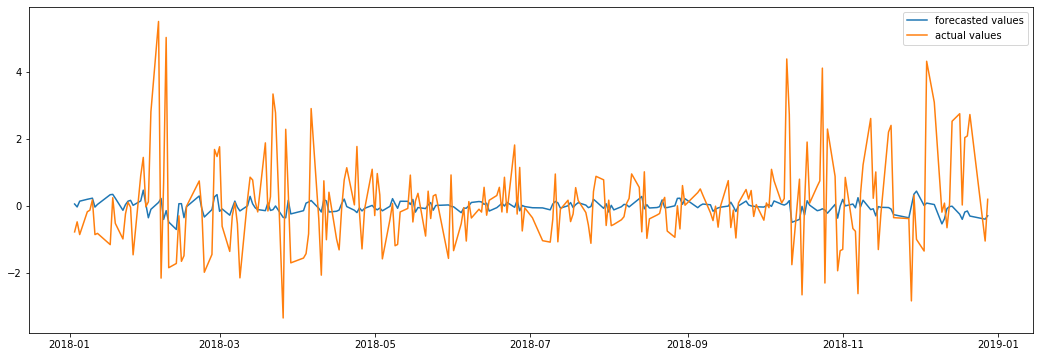

In [52]:
plt.figure(figsize = (18, 6))
plt.plot(data_te.index,ret_forecast_ind[:,0], label = 'forecasted values')
plt.legend()
plt.plot(data_te.index,data_te['sp500'].values, label = 'actual values')
plt.legend()
plt.show()

In [53]:
def cal_mase(train,
             test,
             forecasted):
    mas = mean_absolute_error(forecasted, test)
    mas_naive = np.abs(train[1:] - train[:-1]).sum() / (len(train) - 1)
    return mas / mas_naive

In [54]:
cal_mase(data_tr['sp500'].values,
         data_te['sp500'].values,
         ret_forecast_ind[:,0])

0.9116527891070603

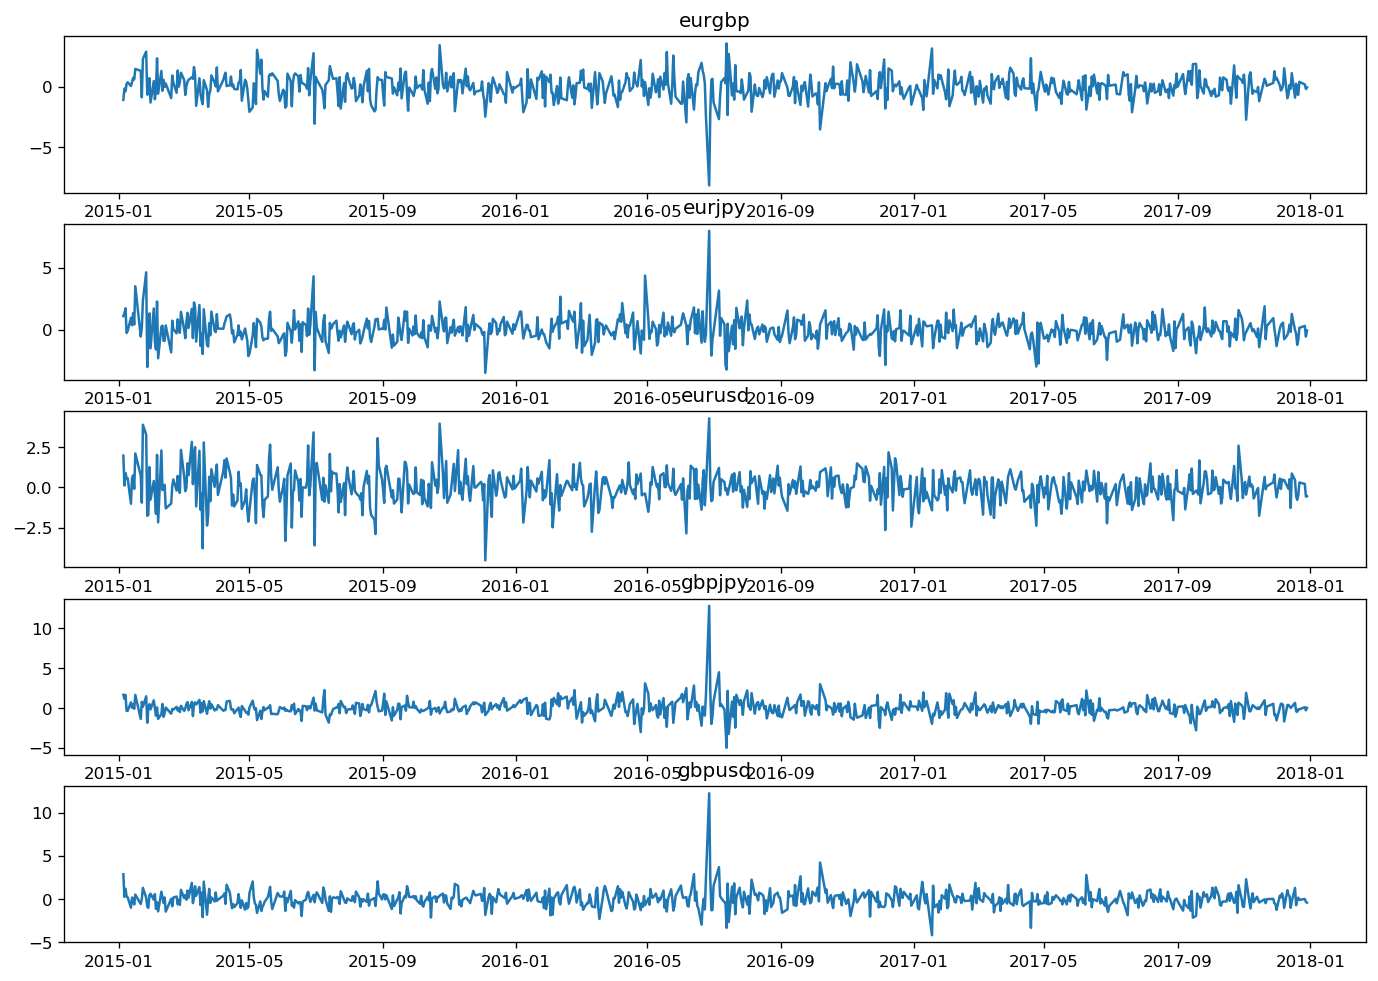

In [84]:
## Plotting
fig, axes = plt.subplots(nrows = len(currencies), dpi = 120, figsize = (14, 10))
for ax, cur in zip(axes, currencies):
    ax.plot(data_tr[cur])
    ax.set_title(cur)

In [59]:
grangers_causation_matrix(data_tr[currencies], variables = data_tr[currencies].columns) 

,eurgbp_x,eurjpy_x,eurusd_x,gbpjpy_x,gbpusd_x
eurgbp_y,1.0000,0.0069,0.0794,0.0070,0.0745
eurjpy_y,0.0040,1.0000,0.2625,0.0044,0.0331
eurusd_y,0.0689,0.0004,1.0000,0.3839,0.0579
gbpjpy_y,0.0024,0.0022,0.2674,1.0000,0.0527
gbpusd_y,0.0909,0.0040,0.1012,0.2047,1.0000


In [60]:
cointegration_test(data_tr[currencies])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
eurgbp ::  623.02    > 60.0627   =>   True
eurjpy ::  421.9     > 40.1749   =>   True
eurusd ::  281.2     > 24.2761   =>   True
gbpjpy ::  172.41    > 12.3212   =>   True
gbpusd ::  77.71     > 4.1296    =>   True


In [61]:
for name, column in data_tr[currencies].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "eurgbp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.9826
 No. Lags Chosen       = 0
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "eurjpy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.372
 No. Lags Chosen       = 0
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "eurusd" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [62]:
model = VAR(data_tr[currencies])
for i in range(1, 10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -14.919267106227075
BIC :  -14.727841338837969
FPE :  3.316236309456722e-07
HQIC:  -14.845351950353496 

Lag Order = 2
AIC :  -14.98777321541268
BIC :  -14.636443034989727
FPE :  3.096692245480682e-07
HQIC:  -14.852105449332246 

Lag Order = 3
AIC :  -15.010680496258756
BIC :  -14.499096435537748
FPE :  3.0266382601957905e-07
HQIC:  -14.813117152786907 

Lag Order = 4
AIC :  -14.986774317285308
BIC :  -14.314585646353017
FPE :  3.1000126332627796e-07
HQIC:  -14.727171900662736 

Lag Order = 5
AIC :  -15.000495727605866
BIC :  -14.16735044758643
FPE :  3.0580017674883367e-07
HQIC:  -14.67871021082642 

Lag Order = 6
AIC :  -14.990968625078
BIC :  -13.996513461779045
FPE :  3.087625843940845e-07
HQIC:  -14.606855447199495 

Lag Order = 7
AIC :  -14.94786744684248
BIC :  -13.791747844360646
FPE :  3.224124890019586e-07
HQIC:  -14.501281510280222 

Lag Order = 8
AIC :  -14.902890426577605
BIC :  -13.584750540863169
FPE :  3.373154614268707e-07
HQIC:  -14.39368609438055

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [63]:
res = model.fit(3)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Aug, 2020
Time:                     23:27:21
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -14.4991
Nobs:                     715.000    HQIC:                  -14.8131
Log likelihood:           373.613    FPE:                3.02664e-07
AIC:                     -15.0107    Det(Omega_mle):     2.70959e-07
--------------------------------------------------------------------
Results for equation eurgbp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.002187         0.037434            0.058           0.953
L1.eurgbp        -1.263718         1.134657           -1.114           0.265
L1.eurjpy         0.757174         1.336059            0.567           0.57

In [64]:
cur_test_pred_input = np.vstack((data_tr[currencies].values[-3:], data_te[currencies].values[:-1]))
ret_forecast_cur = res.forecast(cur_test_pred_input[0:3], steps = 1)
for i in range(1, len(cur_test_pred_input)-2):
    ret_forecast_cur = np.append(ret_forecast_cur, res.forecast(cur_test_pred_input[i:(i+3)] ,steps = 1), axis = 0)

In [65]:
mase_cur = np.array([])
for ind, column_name in enumerate(data_tr[currencies].columns):
    mase_cur = np.append(mase_cur, cal_mase(data_tr[column_name].values,
                                            data_te[column_name].values,
                                            ret_forecast_cur[:,ind]))

In [75]:
for ind, column_name in enumerate(data_tr[currencies].columns):
    print(column_name, "=", mean_absolute_error(ret_forecast_cur[:,ind], data_te[column_name].values))

eurgbp = 0.4640248434401408
eurjpy = 0.5846448013833108
eurusd = 0.6002951845551142
gbpjpy = 0.546093081267736
gbpusd = 0.6274753977883695


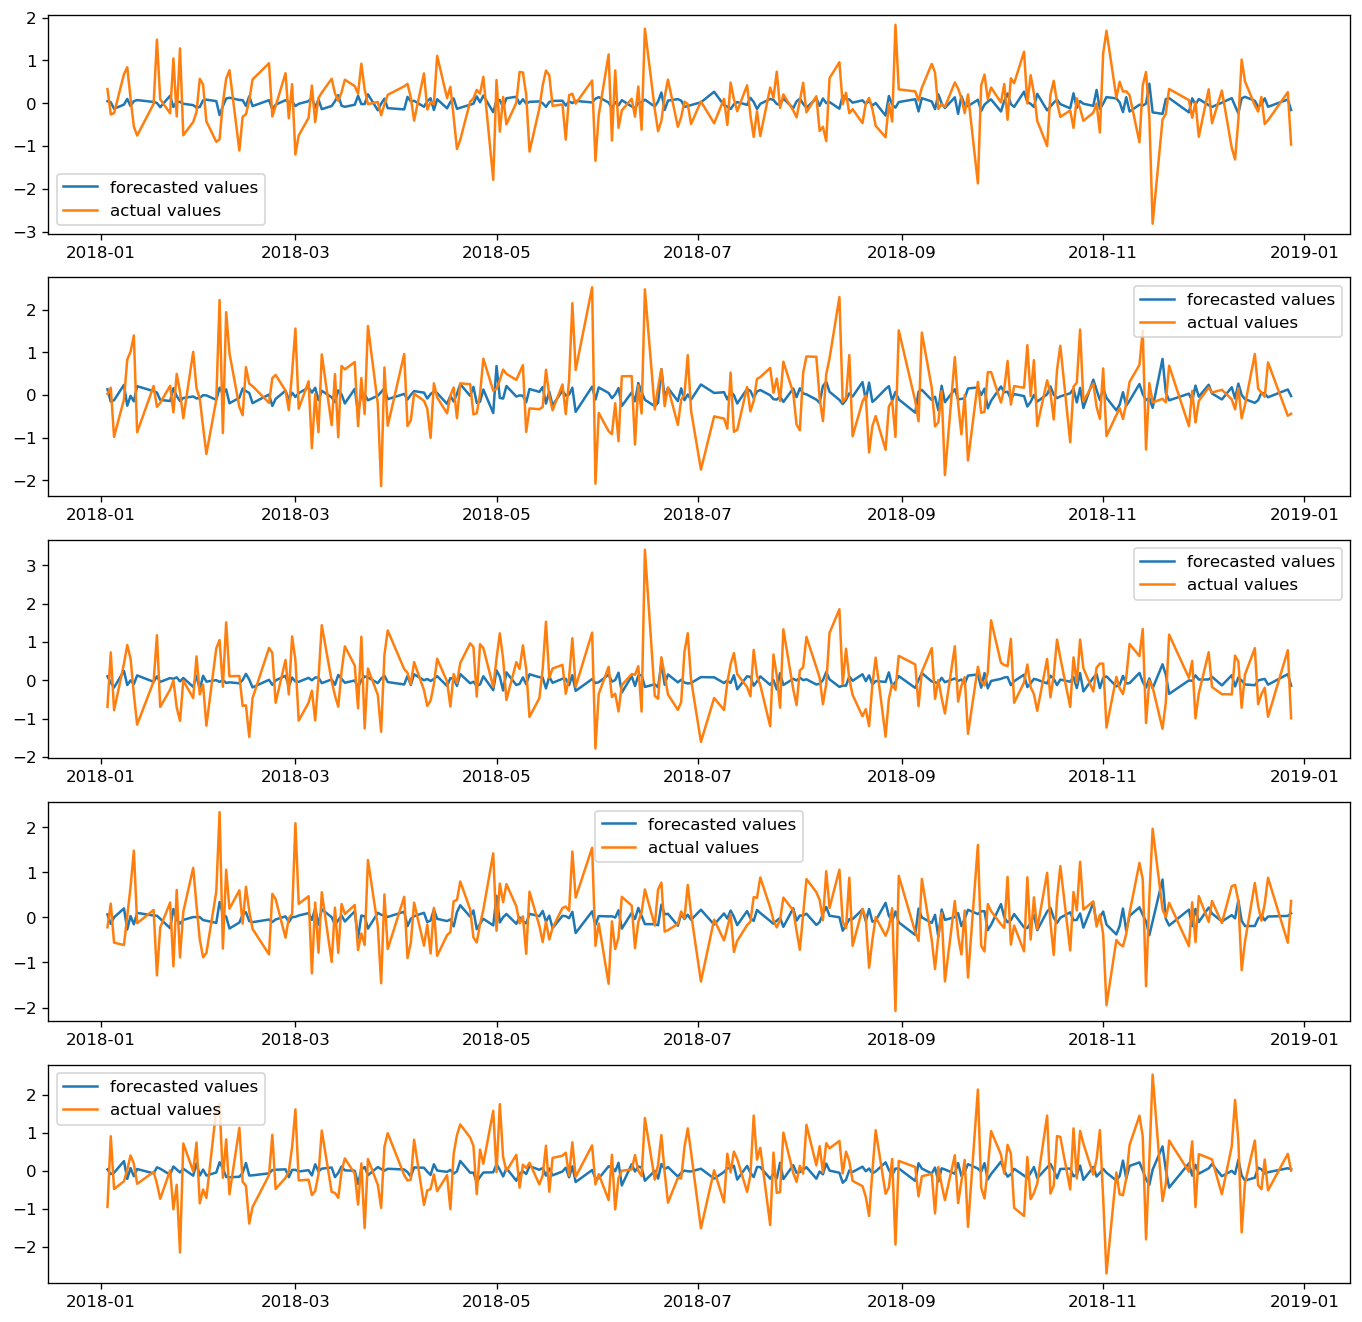

In [100]:
fig, axes = plt.subplots(nrows = len(currencies), dpi = 120, figsize = (14, 14))
for i in range(0, len(currencies)):
    axes[i].plot(data_te.index,ret_forecast_cur[:,i], label = 'forecasted values')
    axes[i].legend()
    axes[i].plot(data_te.index,data_te[currencies[i]].values, label = 'actual values')
    axes[i].legend()

plt.show()